# Disable GPU

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Imports

In [2]:
%matplotlib inline
import importlib
from tqdm import tqdm
import numpy as np
from keras.layers import BatchNormalization, Activation, Conv2D, Add, Input
from keras.layers import MaxPool2D, GlobalAvgPool2D, Dense
from keras.models import Model
import keras.backend as K

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/mkk/anaconda3/envs/pmi36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Test simple network

In [3]:
class ConvBlock():    
    def __init__(self, filter_mult, activation='relu', padding='same'):
        self.layers = dict(
            bn1 = BatchNormalization(),
            ac1 = Activation(activation),
            conv1 = Conv2D(32 * filter_mult, (3, 3), activation="linear", padding="valid"),
            bn2 = BatchNormalization(),
            ac2 = Activation(activation),
            conv2 = Conv2D(32 * filter_mult, (3, 3), activation="linear", padding="valid")            
        )
    def __call__(self, input_x):
        x = self.layers['bn1'](input_x)
        x = self.layers['ac1'](x)
        x = self.layers['conv1'](x)
        x = self.layers['bn2'](x)
        x = self.layers['ac2'](x)
        x = self.layers['conv2'](x) 
        return x


activation = 'linear'
padding='same'
def model_build_func(input_shape):
    print(input_shape)
    inp = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (5, 5), padding=padding, activation=activation)(inp)
    x = ConvBlock(1, activation, padding)(x)
    x = MaxPool2D()(x)
    x = ConvBlock(2, activation, padding)(x)
    x = MaxPool2D()(x)
    x = Conv2D(128, (3, 3), activation=activation, padding=padding, name='c0')(x)
    x = Conv2D(128, (3, 3), activation=activation, padding=padding, name='conv')(x)

    model = Model(inp, x)
    return model

model = model_build_func(input_shape=(None, None, 3))
model.summary()

(None, None, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 32)    128       
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 32)    0    

## Load example image

In [4]:
from receptivefield.image import get_default_image

image = get_default_image(shape=(64, 64), tile_factor=0)
image.shape

(64, 64, 3)

## Compute RF params for that network

In [5]:
from receptivefield.keras import KerasReceptiveField

rf = KerasReceptiveField(model_build_func, init_weights=True)

rf_params = rf.compute(input_shape=image.shape, input_layer='input_image', output_layer='conv')

rf_params

/home/mkk/anaconda3/envs/pmi36/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


ImageShape(w=64, h=64, c=3)


[2017-11-25 21:42:33,986][WARNING][       keras.py]::Layer type <class 'keras.engine.topology.InputLayer'> is not supported
[2017-11-25 21:42:33,987][DEBUG][       keras.py]::Setting weights for layer conv2d_6
[2017-11-25 21:42:34,447][WARNING][       keras.py]::Layer type <class 'keras.layers.normalization.BatchNormalization'> is not supported
[2017-11-25 21:42:34,448][DEBUG][       keras.py]::Setting weights for layer conv2d_7
[2017-11-25 21:42:34,494][WARNING][       keras.py]::Layer type <class 'keras.layers.normalization.BatchNormalization'> is not supported
[2017-11-25 21:42:34,495][DEBUG][       keras.py]::Setting weights for layer conv2d_8
[2017-11-25 21:42:34,526][WARNING][       keras.py]::MaxPool2D detected: max_pooling2d_3. Replace it with AvgPool2D in order to obtain better receptive field mapping estimation
[2017-11-25 21:42:34,527][WARNING][       keras.py]::Layer type <class 'keras.layers.pooling.MaxPooling2D'> is not supported
[2017-11-25 21:42:34,528][WARNING][       

ReceptiveFieldDescription(offset=(6.5, 6.5), stride=(4.0, 4.0), size=Size(w=33, h=33))

In [6]:
rf.input_shape

GridShape(n=None, w=64, h=64, c=3)

In [7]:
rf.output_shape

GridShape(n=None, w=13, h=13, c=1)

### Plot example receptive field response

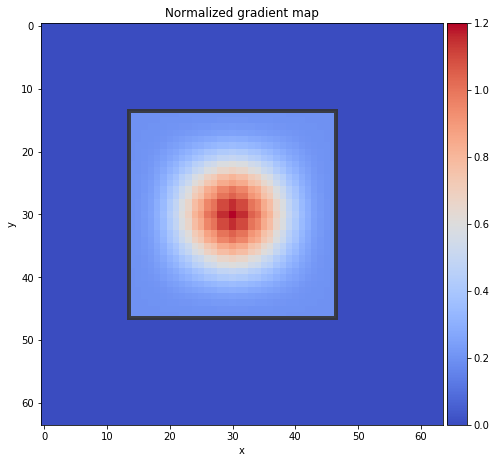

In [8]:
rf.plot_gradient_at((6, 6), image=None, figsize=(7, 7))

### Debug receptive field

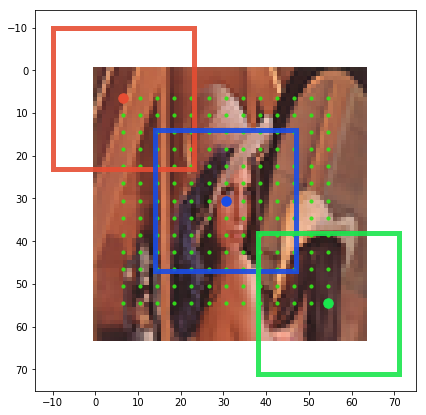

In [9]:
rf.plot_rf_grid(custom_image=image, figsize=(7, 7))

## Test inception network

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [11]:
def inception_build_func(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape, name='input_image')
    model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=None)
    return model

inception_model = inception_build_func()

In [12]:
inception_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_image (InputLayer)         (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 111, 111, 32)  864         input_image[0][0]                
____________________________________________________________________________________________________
batch_normalization_9 (BatchNorm (None, 111, 111, 32)  96          conv2d_11[0][0]                  
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 111, 111, 32)  0           batch_normalization_9[0][0]      
___________________________________________________________________________________________

## Receptive field for layer `mixed4`

Note that there are 10 `mixed` layers but allready at 4-th one receptive field is bigger than
input image.

In [13]:
from receptivefield.keras import KerasReceptiveField
from receptivefield.image import get_default_image

image = get_default_image(shape=(224, 224), tile_factor=1)

inception_rf = KerasReceptiveField(inception_build_func, init_weights=False)
inception_rf.compute(input_shape=image.shape, input_layer='input_image', output_layer='mixed4')

[2017-11-25 21:02:07,951][ INFO][       keras.py]::Feature map shape: [None, 40, 40, 1]
[2017-11-25 21:02:07,953][ INFO][       keras.py]::Input shape      : (None, 672, 672, 3)
[2017-11-25 21:02:17,445][DEBUG][      common.py]::Computing receptive field at center (20, 20) with offset GridPoint(x=0, y=0)
[2017-11-25 21:02:27,781][DEBUG][      common.py]::Computing receptive field at center (20, 20) with offset GridPoint(x=1, y=1)


ReceptiveFieldDescription(offset=(15.5, 15.5), stride=(16.0, 16.0), size=Size(w=339, h=339))

In [14]:
inception_rf.output_shape

GridShape(n=None, w=40, h=40, c=1)

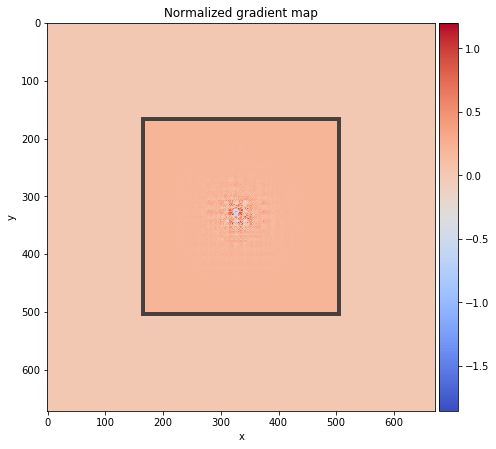

In [16]:
inception_rf.plot_gradient_at((20, 20), image=None, figsize=(7, 7))

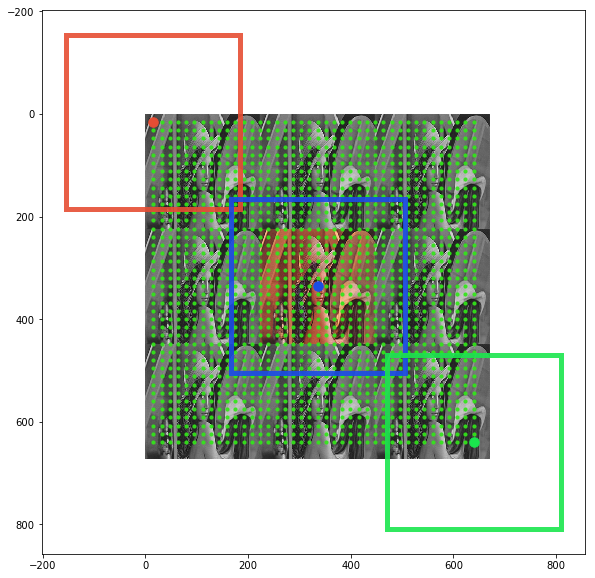

In [17]:
inception_rf.plot_rf_grid(custom_image=image, figsize=(10, 10))